# Entity Extraction

### Package imports

In [147]:
import json, re, os, tweepy, nltk, random
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize, pos_tag, ne_chunk
from parameters import user, number_of_tweets
from nltk.tree import Tree
from wordcloud import WordCloud

%matplotlib inline
%run core/secrets.py
%run core/parameters.py
%run core/model.py

[nltk_data] Downloading package punkt to /Users/tomewing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tomewing/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomewing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tomewing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/tomewing/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/tomewing/nltk_data...
[nltk_data]   Package words is already up-to-date!


### extract_data function

In [108]:
def twitter_authenticate():
    '''
    Authenticates to the Twitter API and returns a cursor
    '''
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    return api

def extract_data(user):
    '''
    Extracts the specified number of tweets from the specified user and 
    returns two list objects:
        raw_tweets_output: The raw tweet data including metadata
        raw_tweets_text: Just the text from the tweet
    '''
    
    # Create the cursor
    api = twitter_authenticate()  

    # Retrieve user tweets
    raw_tweets_input = api.user_timeline(
        screen_name = user, 
        tweet_mode = 'extended', 
        count = 3200
    )

    # Extract relevent data from tweets & save to a data structure

    raw_tweets_output = []

    for tweet in raw_tweets_input:
        output_dict = {}
        output_dict['id'] = tweet._json['id_str']
        output_dict['text'] = tweet._json['full_text']
        output_dict['created'] = tweet._json['created_at']
        output_dict['favorite_count'] = tweet._json['favorite_count']
        output_dict['retweet_count'] = tweet._json['retweet_count']
        output_dict['retweeted'] = tweet._json['retweeted']
        output_dict['entities'] = tweet._json['entities']
        raw_tweets_output.append(output_dict)

    # Create a data structure for the text only

    raw_tweets_text = [tweet['text'] for tweet in raw_tweets_output]
    
    return raw_tweets_input, raw_tweets_output, raw_tweets_text

### clean_data function

In [12]:
def clean_data(raw_tweets_text):
    '''
    Takes the raw tweets list as an input and cleans the data removing hyperlinks, hashtags, emojis,
    converting to lower case, removing numbers, stopwords, punctuation and then lemmatizes the individual words
    for consistency before tokenizing into separate datastructures for tweets sentences and words. 
    
    Returns five list objects as follows:
    
        clean_words: Cleaned tweets tokenized into words.
        clean_sentences: Cleaned tweets tokenized into sentences.
        clean_tweets: Cleaned tweets.      
    
    '''
    

    # Building the output data structures
    clean_words = []
    clean_sentences = []
    clean_tweets = []

    # Iterate through the tweets, clean and append data to output data structures
    for tweet in raw_tweets_text:
        
        tweet = re.sub(r"http\S+", "", tweet)                            # Remove hyperlinks
        tweet = re.sub(r"#\S+", "", tweet)                               # Remove hashtags
        tweet = emoji_pattern.sub(r'', tweet)                            # Remove emojis
        tweet = tweet.replace('&amp;', '&')                              # Sort out ampersands
        tweet = tweet.replace(',', '')                                   # Remove commas
        tweet = tweet.replace('@','')                                    # Remove mention symbol
        tweet = tweet.replace('...','')                                  # Remove triple dots
        
        # Output Variables
        output_tweet = tweet
        output_sentences = sent_tokenize(tweet)                    
        output_words = word_tokenize(tweet)
        
        # Appending the clean data to the output data structures
        
        clean_words.append(output_words)
        clean_sentences.append(output_sentences)
        clean_tweets.append(output_tweet)
        
    return clean_words, clean_sentences, clean_tweets

### Execution

In [13]:
raw_tweets_output, raw_tweets_text = extract_data(user)                            # Extracting the data
clean_words, clean_sentences, clean_tweets = clean_data(raw_tweets_text)           # Output Data
reader = read_gmb(ner_corpus_root)                                                 # Creating the reader
model_data = list(reader)                                                          # Creating the model
chunker = NamedEntityChunker(model_data)                                           # Chunking the data
outputs = [chunker.parse(pos_tag(word_tokenize(tweet))) for tweet in clean_tweets] # Applying the data to the model

### Formatting the output

In [32]:
# Creating an output for the model

output_json = []
for tweet in outputs:
    tweet_output = []
    for word_data in tweet:
        if type(word_data) == nltk.tree.Tree:
            output_data = {}
            output_data['text'] = ''
            output_data['label'] = word_data.label()
            for item in word_data.leaves():
                if output_data['text'] == '':
                    output_data['text'] = item[0]
                else:
                    output_data['text'] = '{} {}'.format(output_data['text'], item[0])
            tweet_output.append(output_data)
    output_json.append(tweet_output)
    
# Creating the output data structure

count_data = {
    'geo' : [],    # Geographical Entity
    'org' : [],    # Organization
    'per' : [],    # Person
    'gpe' : [],    # Geopolitical Entity
    'tim' : [],    # Time indicator
    'art' : [],    # Artifact
    'eve' : [],    # Event
    'nat' : []     # Natural Phenomenon
}

# Filling the output data structure with the model data

count_data_keys = list(count_data.keys())

for tweet in output_json:
    for tag in tweet:
        for category in count_data_keys:
            if tag['label'] == category:
                count_data[category].append(tag['text'])
                
cleaned_count_data = {}

### Manually Cleaning the count data and visualising

In [123]:

cleaned_count_data['geo'] = [
'Missouri',
'Main Street',
'United States',
'Parkland ca',
'United States',
'Government',
'United States',
'United States',
'United States',
'Immigration Studies',
'California',
'Rex Tillerson',
'Astros',
'Nancy Pelosi',
'Border',
'Barriers',
'United States',
'Collusion with',
'Russia',
'Pennsylvania',
'VOTE',
'Pennsylvania',
'United States',
'United States',
'North Korea',
'FAKE.They',
'North Korea',
'Pennsylvania',
'Spoke',
'Japan',
'North Korea',
'Japan',
'North Korea',
'United States',
'China',
'Kristian Saucier',
'Yountville',
'North Korea',
'Spoke',
'Australia',
'Australia',
'Australia',
'United States',
'Pennsylvania',
'Rick Saccone4PA18',
'North Korea',
'Aluminum',
'United States',
'Steel',
'United States',
'Cabinet',
'Steel',
'China',
'United States',
'China',
'Country',
'Country',
'North Korea',
'United States',
'Maryland',
'HISTORY',
'SeanHannity',
'TuckerCarlson',
'Dems',
'Mexico',
'Mexico',
'Canada',
'United States',
'Steel',
'Aluminum',
'United States',
'Washington',
'United States',
'United States',
'T.V',
'SNL',
'U.S',
'JOBS JOBS JOBS',
'SMART TRADE',
'Bill',
'SAFE',
'Florida',
'God',
'Florida',
'Los Angeles',
'Madison Square Garden',
'Chamber',
'Christ',
'God’s',
'I.G',
'California',
'United States',
'Mississippi',
'Texas',
'Texas',
'United States',
'COLLUSION.I',
't',
'DACA',
'JudgeJeanine',
'Russia',
'DNC',
'Pennsylvania',
'United States',
'United States',
'United States',
'Australia',
'Allegiance',
'South Korea',
'El Salvador',
'Mexico',
'Mexico',
'School Safety',
'NRA',
'Bump Stocks',
'Billy Graham',
'Valor',
'Russia',
'Accusation',
'Trump',
'Russia',
'Pennsylvania',
'CPAC',
'Dems',
'Dems',
'United States',
'Russia',
'Crimea',
'Syria',
'Utah',
'OrrinHatch',
'NASCAR',
'France',
'Dems',
'Russia',
'Moscow',
'United States',
'Russia',
'Russia',
'China',
'Russia',
'CASH',
'Iran',
'Collusion',
'Russia',
'Crooked H the',
'Dems',
'Florida',
'Funny',
'Florida',
'Florida',
'Russia',
'Florida',
'Florida',
'DHSgov',
'United States”',
'DHSgov',
'Congress',
'DACA',
'Merit Based Immigration',
'Florida'
]

In [127]:
cleaned_count_data['per'] = [
'Larry Kudlow',
 'Please',
 'Thank',
 'God',
 'God',
 'Mike Pompeo',
 'Gina Haspel',
 'Rick Saccone',
 'Rick Saccone',
 'Bump Stocks',
 'Secretary',
 'Rick Saccone',
 'Hillary CLinton',
 'John Dowd',
 'Ty Cobb',
 'Jay Sekulow',
 'Rick Saccone',
 'Big Deficit',
 'Rick Saccone',
 'Prime Minister Abe',
 'Xi Jinping',
 'Kim Jong Un',
 'Xi Jinping',
 'Rick Saccone',
 'Kim Jong Un',
 'Melania Trump',
 'From',
 'Bad Policies',
 'Must WIN',
 'MarkBurnettTV RealRomaDowney From Bush',
 'Donald Trump',
 'Barack Obama',
 'Lowest rated',
 'Problem',
 'Donald Trump',
 'RT EricTrump',
 'Why',
 'Barack Obama',
 'Massive',
 'Eric',
 'Alec Baldwin',
 'Good',
 'Ivanka Trump',
 'RT Scavino45',
 'Donald Trump',
 'Consumer Confidence',
 'Our Steel',
 'Background Checks',
 'Billy Graham',
 'Billy Graham',
 'Billy Graham',
 'Billy Graham',
 'Why',
 'Jeff Sessions',
 'Ice',
 'OUR COUNTRY MUST',
 'Ronald Reagan',
 'Thomas Binion',
 'Donald Trump “',
 'George P. Bush',
 'Sid Miller',
 'Donald Trump',
 'Comptroller Glenn Hegar',
 'Greg Abbott',
 'Ted Cruz',
 'Dan Patrick',
 'Ken Paxton',
 'James Comey',
 'it.',
 'Ken Starr',
 'Jonathan Turley',
 'Hillary Clinton ’',
 'RT WhiteHouse',
 'RT VollrathTammie',
 'Donald Trump',
 'Donald Trump',
 'Congressman Schiff',
 'Donald Trump',
 'Witch Hunt',
 'Barack Obama',
 'Dem Memo :',
 'Donald Trump',
 'Donald Trump',
 'Donald Trump',
 'DACA beneficiaries',
 'Nancy Pelosi',
 'Thank',
 'Melania Trump',
 'Malcolm Turnbull',
 'Mrs. Turnbull',
 'Billy Graham',
 'Ivanka Trump',
 'El Salvador',
 'Wayne Chris',
 'Cowards',
 'Melina Trump',
 'Billy Graham',
 'Barack Obama',
 'Main Street',
 'Barack Obama',
 'Original',
 'Matt Schlapp',
 'Barack Obama',
 '.The',
 'Barack Obama',
 'Hillary Clinton',
 'Donald Trump',
 'Thank',
 'Donald Trump',
 'David Brody',
 'Scott Lamb',
 'Senator',
 'Barack Obama',
 'Donald Trump',
 'DOnald Trump ’',
 'Oprah Winfrey',
 'Oprah Winfrey',
 'Brian France',
 'Thank',
 'John McLaughlin',
 'Ronald Reagan',
 'Donald Trump',
 'Adam Schiff',
 'Barack Obama',
 'Hillary Clinton',
 'wasn',
 'Adam Schiff',
 'Barack Obama',
 'Donald Trump',
 'Barack Obama',
 'General McMaster',
 'Mike Pence',
 'Donald Trump',
 'Donald Trump',
 'Rod Rosenstein',
 'Don A',
 'Michael Goodwin',
 'Will',
 'Donald Trump',
 'Dems',
 'RT SpoxDHS'
]

In [128]:
cleaned_count_data['gpe'] = [
 'Ambassadors',
 'Judges',
 'American',
 'Americans',
 'Rasmussen',
 'Epic',
 'Chinese',
 'Congratulations',
 'Happy',
 'Great',
 'Possible',
 'Total',
 'Crooked',
 'Russian',
 'American',
 'Aluminum',
 'American',
 'Mainstream',
 'Jobless',
 'Unemployment',
 'Many',
 'Bible',
 'Obama',
 'Heritage',
 'Big',
 'American',
 'American',
 'RT',
 'RT',
 'Dems',
 'Unemployment',
 'Democrat',
 'Armed',
 'Lowest',
 'Our',
 'We',
 'American',
 'OUR',
 'My',
 'Question',
 'Russian',
 'Bad',
 'Reform',
 'False',
 'Russian',
 'Russian',
 'Russian',
 'RT',
 'Russian',
 'Russian “',
 'Russian',
 'Russian',
 'Very',
 'Russian',
 'Russian',
 'Vice',
 'Russian',
 'Presidential Proclamation'
]

In [129]:
### WordClouds

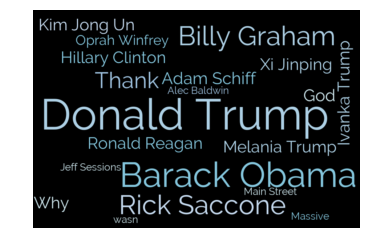

In [149]:
def random_color(font_size, position, orientation, random_state=None, **kwargs):
    '''
    Generates a random colour selection from the DfT colour scheme for
    the word cloud.
    '''

    colour = [
        'rgba(207, 232, 239, 1)',
        'rgba(198, 219, 240, 1)',
        'rgba(174, 209, 230, 1)',
        'rgba(160, 196, 226, 1)',
        'rgba(133, 199, 222, 1)'
	]

    return random.choice(colour)

def dict_maker(list_object):
    unique_set = set(list_object)
    unique_list = list(unique_set)
    output_data = {}
    
    for item in unique_list:
        output_data[item] = list_object.count(item)
    
    return output_data

geo_dict = dict_maker(cleaned_count_data['geo'])
gpe_dict  = dict_maker(cleaned_count_data['gpe'])
per_dict  = dict_maker(cleaned_count_data['per'])

def word_cloud(data, name):
    '''
    Generates a wordcloud based upon the input paramters
    '''

    wordcloud = WordCloud(
    	font_path = './fonts/Raleway.ttf',
    	background_color = 'black',
        max_words = 20,
        width = 900,
        height = 600
    ).generate_from_frequencies(data)
    
    plt.imshow(wordcloud.recolor(color_func=random_color, random_state=3),interpolation="bilinear")
    plt.axis("off")
    plt.imsave("./outputs/{}.png".format(name),wordcloud)
    
word_cloud(geo_dict, "Geo")
word_cloud(gpe_dict, "Gpe")
word_cloud(per_dict, "Per")

In [145]:
raw_tweets_input, raw_tweets_output, raw_tweets_text = extract_data(user)
raw_tweets_output[10]

{'created': 'Wed Mar 14 13:02:11 +0000 2018',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 79010,
 'id': '973907142649397251',
 'retweet_count': 23415,
 'retweeted': False,
 'text': 'Hundreds of good people, including very important Ambassadors and Judges, are being blocked and/or slow walked by the Democrats in the Senate. Many important positions in Government are unfilled because of this obstruction. Worst in U.S. history!'}

### spare code

In [ ]:
from nltk.stem import WordNetLemmatizer

output_words = word_tokenize(tweet)                      # Removes punctuation from the tweet and outputs as words   
output_sentences = remove_punc.tokenize_sents(sentences) # Removes punctuation from the sentences and outputs as sentences
output_tweet = re.sub(r'\W+', ' ', tweet)                # Removes punctuation from the tweet an outputs

# Lemmatize the individual words - need to move this as it messes with POS

lemmatizer = WordNetLemmatizer()                         # Initialising the lemmatizer
[lemmatizer.lemmatize(word) for word in words]